In [10]:
import pandas as pd
import numpy as np

In [11]:
metadata = pd.read_csv("data/train/metadata.csv")

In [12]:
metadata["file_name"][:] = "data/train/" + metadata["file_name"][:]
metadata.head(5)

,file_name,text
0,data/train/1-1.png,Tommy Hilfiger men's Embroidered Tommy Logo Gr...
1,data/train/1-2.png,Tommy Hilfiger men's Embroidered Tommy Logo Gr...
2,data/train/2-1.png,Tommy Hilfiger men's Regular Fit Long-Sleeve W...
3,data/train/2-2.png,Tommy Hilfiger men's Regular Fit Long-Sleeve W...
4,data/train/3-1.png,Tommy Hilfiger men's Regular Fit Stripe Classi...


In [13]:
import datasets
from datasets import load_dataset, Image

In [14]:
features = datasets.Features({
    'image': datasets.Image(),
    'text': datasets.Value('string'),

})

dataset_dict = {
    'image': metadata["file_name"].values,
    'text': metadata["text"].values,
}

dataset = datasets.Dataset.from_dict(dataset_dict, features)

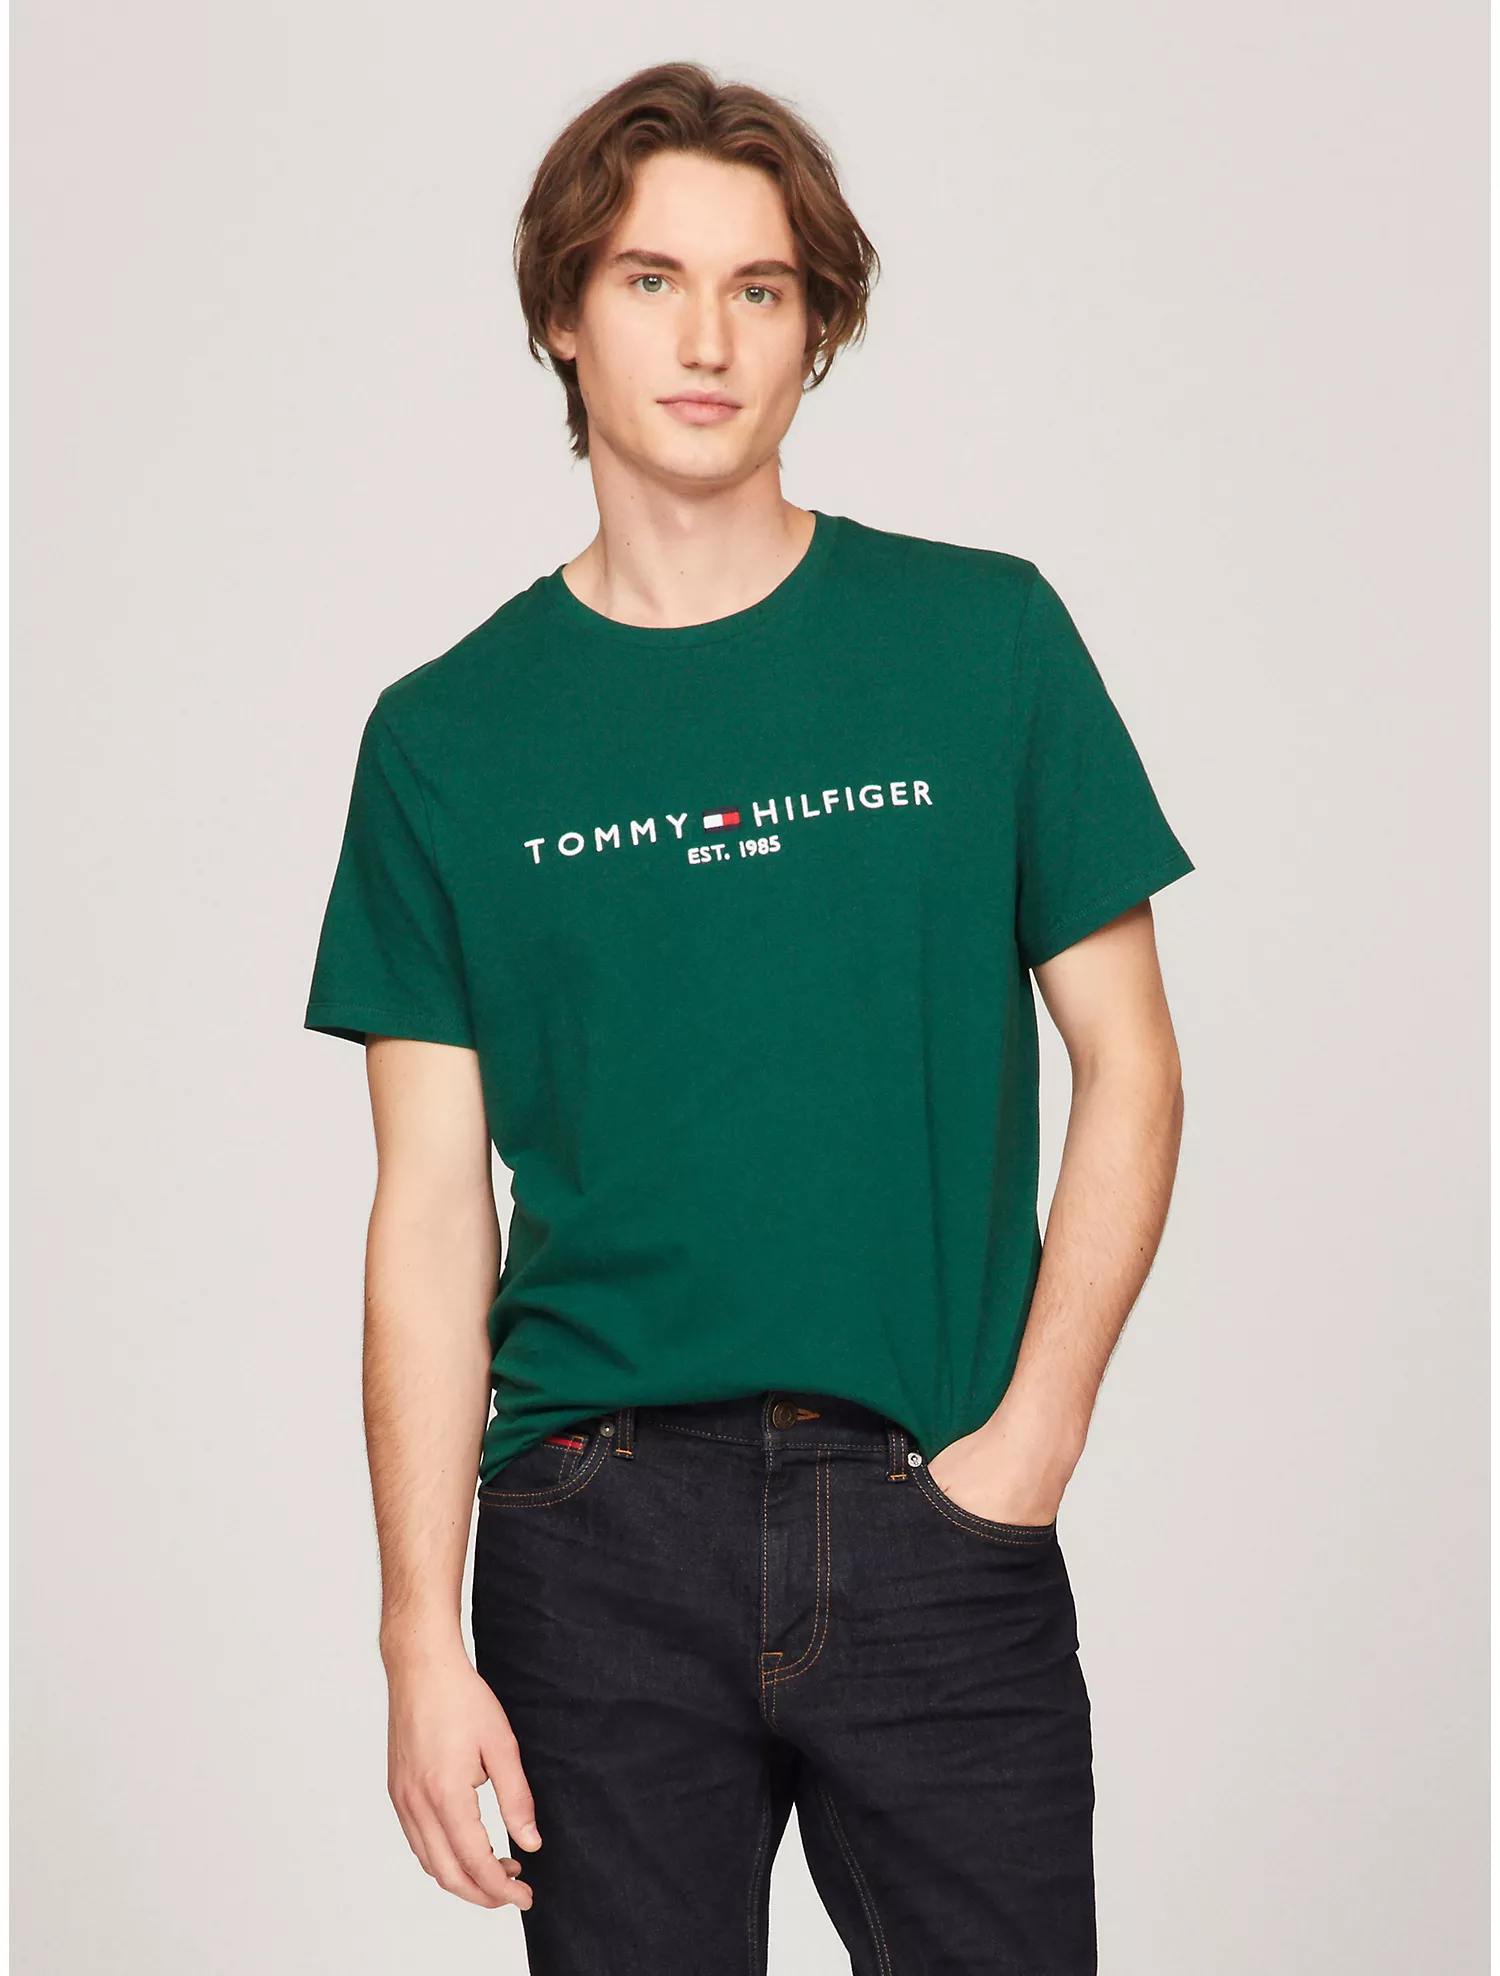

In [15]:
dataset[0]["image"]

In [71]:
from huggingface_hub import HfApi, HfFolder

# set api for login and save token
HfFolder.save_token('***')

In [ ]:
dataset.push_to_hub('jwl25b/final_project_dataset')

In [17]:
import os
import braceexpand
import webdataset as wds
from pathlib import Path
import torchvision.transforms as T

In [18]:
outputFileName = []
for i in range(51):
    outputFileName.append('{0:04}'.format(i))

In [40]:
def get_class_label(index):
    return metadata['text'][index]

# Create a TarWriter object to write the dataset to a tar archive
index = 0
    # Iterate over the files in the dataset directory
for root, dirs, files in os.walk("data/train/"):
    # Iterate over the files in each subdirectory
    for filename in files:
        if filename.endswith(('.png')):
            # Construct the path to the file
            filename = Path(filename).stem
            with wds.TarWriter(f"{outputFileName[index]}.tar") as tar:
                path = os.path.join(root, filename)
                # Get the class label for the file
                class_label = get_class_label(index)
                # Write the file and its metadata to the TarWriter
                with open(f"{path}.png", "rb") as f:
                    tar.write({"__key__": outputFileName[index], "txt": class_label, "jpg": f.read()})
                index=index+1

In [19]:
shards = list(
    braceexpand.braceexpand("dataset/{0000..0049}.tar")
)

In [20]:
total_bs = 2
ds = (
    wds.WebDataset(shards, handler=wds.warn_and_continue)
    .decode("rgb", handler=wds.warn_and_continue)
    .to_tuple("jpg", "txt")  # assumes image is in `jpg` and caption in `txt`
    .batched(total_bs)  # load in batch per worker (faster)
)


In [56]:
%%time
images, captions = next(iter(ds))

CPU times: total: 109 ms
Wall time: 219 ms


In [57]:
images.shape

(2, 1976, 1500, 3)

In [58]:
captions[0]

"Tommy Hilfiger men's Embroidered Tommy Logo Green T-Shirt"

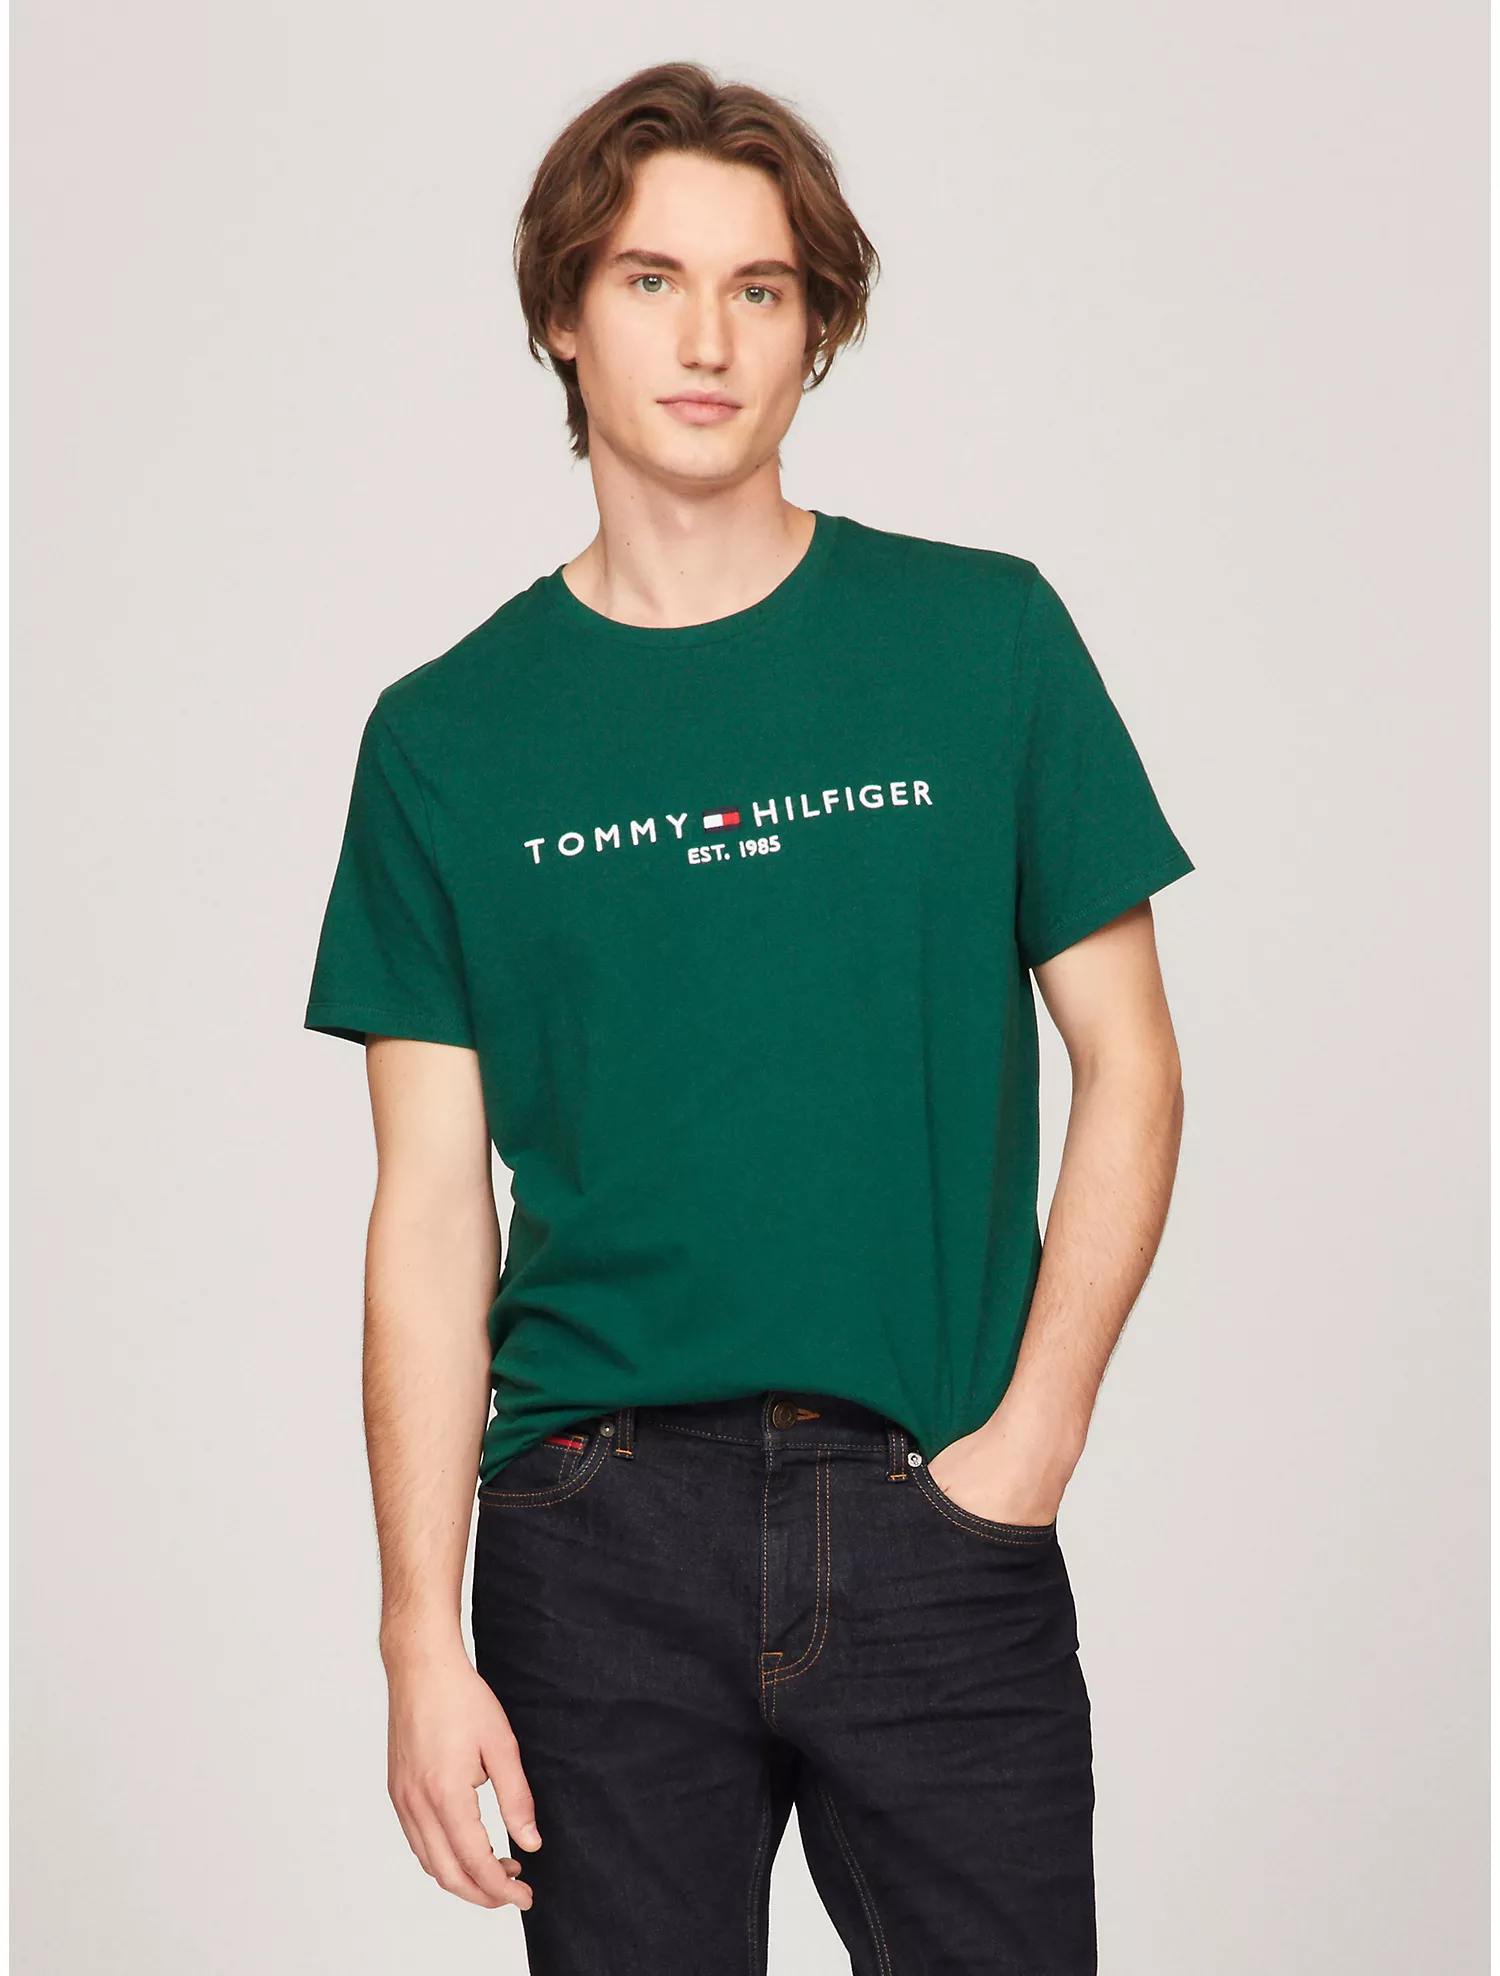

In [59]:
T.ToPILImage()((np.uint8(images[0]*255)))